Kwang Zhe: This model was taken from https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp/data and has been modified to fit the clustering categories we have derived.

# Input

In [8]:
import json
import pandas as pd

with open("data/variables.txt", "r") as file:
    data = json.load(file)

input_sentence = data['input_sentence']

# 1. Import needed libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# 2. Read and Preprocessing data

### 2.1 Read data

In [3]:
df = pd.read_csv("data/emotions-dataset-for-nlp/train.txt",
                 delimiter=';', header=None, names=['sentence','label'])

val_df = pd.read_csv("data/emotions-dataset-for-nlp/val.txt",
                 delimiter=';', header=None, names=['sentence','label'])

ts_df = pd.read_csv("data/emotions-dataset-for-nlp/test.txt",
                 delimiter=';', header=None, names=['sentence','label'])

In [4]:
df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [5]:
df.label.value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

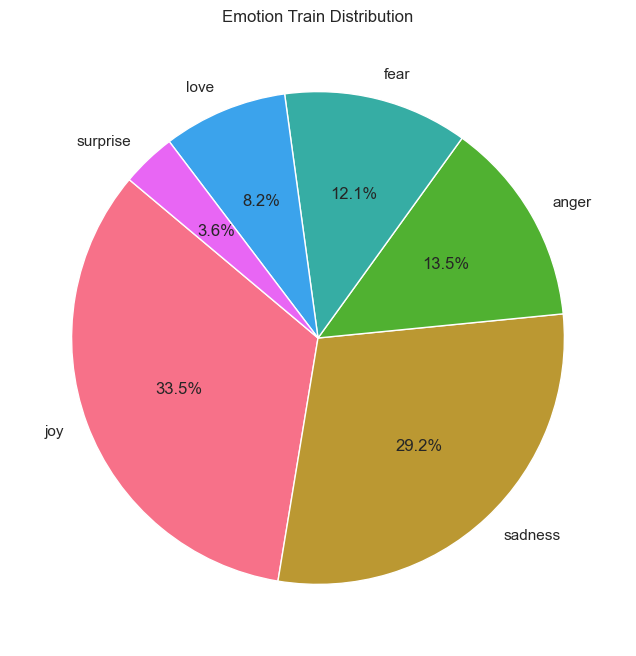

In [6]:
# # Count label distributions
# label_counts = df['label'].value_counts()
# light_colors = sns.husl_palette(n_colors=len(label_counts))
# sns.set(style="whitegrid")
# plt.figure(figsize=(8, 8))
# plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
# plt.title('Emotion Train Distribution')
# plt.show()

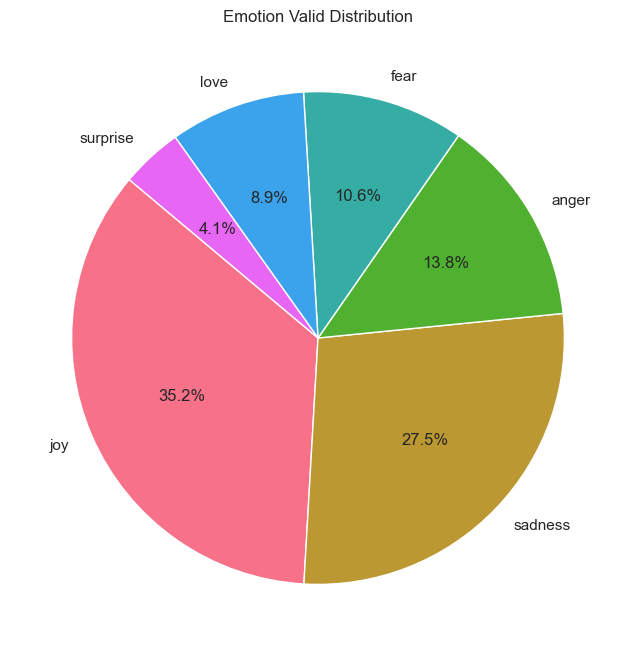

In [7]:
# label_counts = val_df['label'].value_counts()
# light_colors = sns.husl_palette(n_colors=len(label_counts))
# sns.set(style="whitegrid")
# plt.figure(figsize=(8, 8))
# plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
# plt.title('Emotion Valid Distribution')
# plt.show()

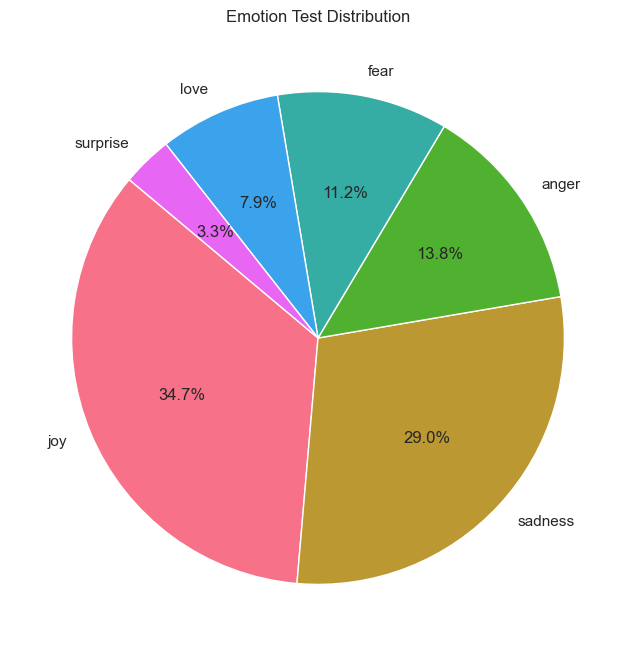

In [8]:
# # Count label distributions
# label_counts = ts_df['label'].value_counts()
# light_colors = sns.husl_palette(n_colors=len(label_counts))
# sns.set(style="whitegrid")
# plt.figure(figsize=(8, 8))
# plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
# plt.title('Emotion Test Distribution')
# plt.show()

### Since we have an unbalanced dataset, we can remove both surprise and love labels since they are the lowest and reduce each label to make the dataset balanced.

Kwang Zhe: For this model, we will also omit Fear as it does not align with our emotion classes.

In [9]:
df = df[~df['label'].str.contains('love')]
df = df[~df['label'].str.contains('surprise')]
df = df[~df['label'].str.contains('fear')]

In [10]:
joy = df[df['label'] == 'joy'].sample(n=2200, random_state=20)
sad = df[df['label'] == 'sadness'].sample(n=2200, random_state=20)
# fear = df[df['label'] == 'fear'].sample(n=1937, random_state=20)
anger = df[df['label'] == 'anger'].sample(n=2159, random_state=20)

df_sampled = pd.concat([joy, sad, anger]) # fear was removed from the concat.

df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [11]:
# df.label.value_counts()

label
sadness    2200
joy        2200
anger      2159
Name: count, dtype: int64

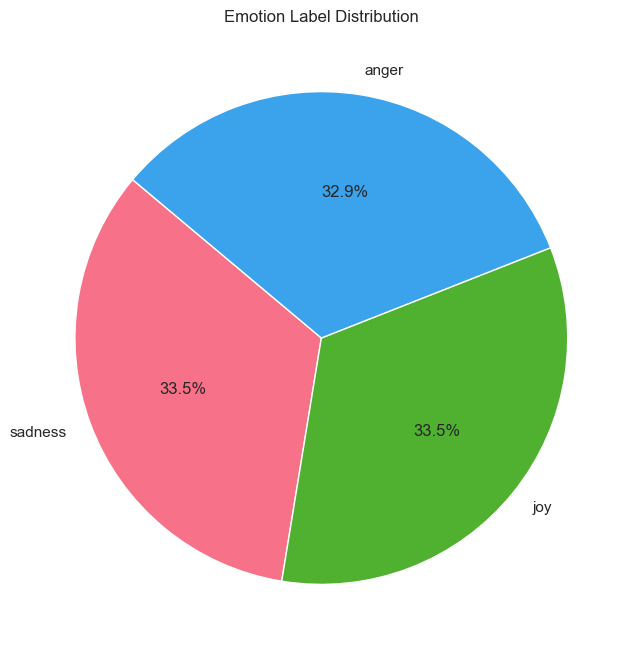

In [12]:
# # Count label distributions
# label_counts = df['label'].value_counts()
# light_colors = sns.husl_palette(n_colors=len(label_counts))
# sns.set(style="whitegrid")
# plt.figure(figsize=(8, 8))
# plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
# plt.title('Emotion Label Distribution')
# plt.show()

In [13]:
# val_df.label.value_counts()

label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

In [14]:
val_df = val_df[~val_df['label'].str.contains('love')]
val_df = val_df[~val_df['label'].str.contains('surprise')]
val_df = val_df[~val_df['label'].str.contains('fear')]

In [15]:
joy = val_df[val_df['label'] == 'joy'].sample(n=250, random_state=20)
sad = val_df[val_df['label'] == 'sadness'].sample(n=250, random_state=20)
# fear = val_df[val_df['label'] == 'fear'].sample(n=212, random_state=20)
anger = val_df[val_df['label'] == 'anger'].sample(n=275, random_state=20)

df_sampled = pd.concat([joy, sad, anger])

val_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

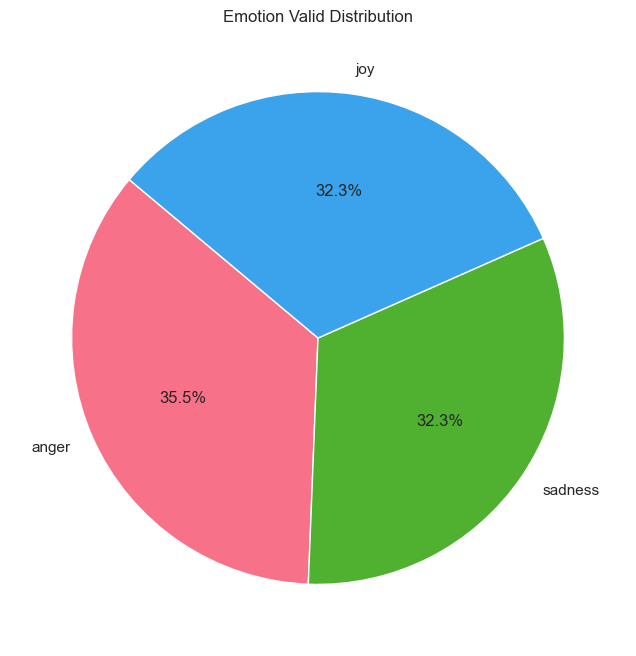

In [16]:
# # Count label distributions
# label_counts = val_df['label'].value_counts()
# light_colors = sns.husl_palette(n_colors=len(label_counts))
# sns.set(style="whitegrid")
# plt.figure(figsize=(8, 8))
# plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
# plt.title('Emotion Valid Distribution')
# plt.show()

In [17]:
ts_df.label.value_counts()

label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [18]:
ts_df = ts_df[~ts_df['label'].str.contains('love')]
ts_df = ts_df[~ts_df['label'].str.contains('surprise')]
ts_df = ts_df[~ts_df['label'].str.contains('fear')]

In [19]:
joy = ts_df[ts_df['label'] == 'joy'].sample(n=250, random_state=20)
sad = ts_df[ts_df['label'] == 'sadness'].sample(n=250, random_state=20)
# fear = ts_df[ts_df['label'] == 'fear'].sample(n=224, random_state=20)
anger = ts_df[ts_df['label'] == 'anger'].sample(n=275, random_state=20)

df_sampled = pd.concat([joy, sad, anger])

ts_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

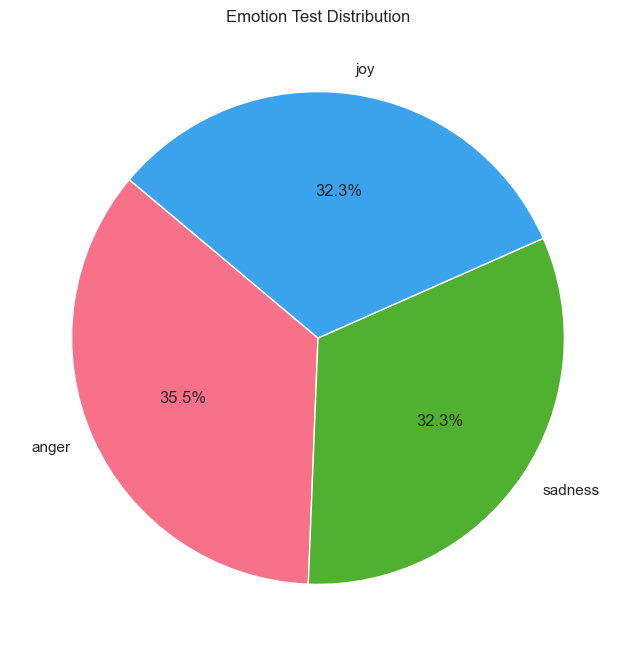

In [20]:
# # Count label distributions
# label_counts = ts_df['label'].value_counts()
# light_colors = sns.husl_palette(n_colors=len(label_counts))
# sns.set(style="whitegrid")
# plt.figure(figsize=(8, 8))
# plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
# plt.title('Emotion Test Distribution')
# plt.show()

Kwang Zhe: Even when leaving it with 3 categories, the data is still very evenly split across all 3 datasets.

### 2.2 Split data into X, y

In [21]:
tr_text = df['sentence']
tr_label = df['label']

val_text = val_df['sentence']
val_label = val_df['label']

ts_text = ts_df['sentence']
ts_label = ts_df['label']

### 2.3 Encoding

In [22]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

### 2.4 Text preprocessing

In [23]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=50) 
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label)

# 3. Building deep learning model

In [24]:
max_words = 10000
max_len = 50
embedding_dim = 32

### 3.1 Model architecture

Kwang Zhe: We will change the output layer's neuron count from 4 to 3 to match the 3 remaining classes, instead of 4 with "fear".

In [25]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(3, activation='softmax')(dropout) # Number of Neurons in the output layers has been reduced from 4 to 3 to align with
                                                       # removing the "fear" category.

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

In [26]:
# model = Sequential()     
# model.add(Embedding(10000, 32, input_length=50))
# model.add(Conv1D(64, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(ReLU())
# model.add(Dropout(.5))
# model.add(GlobalMaxPooling1D(keepdims=True))
# model.add(Conv1D(64, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(ReLU())
# model.add(Dropout(.5))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(6, activation='softmax'))

### 3.2 Compile model

In [27]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 50)]                 0         []                            
 r)                                                                                               
                                                                                                  
 embedding_1_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding (Embedding)       (None, 50, 32)               320000    ['embedding_input[0][0]']     
                                                                                             

In [28]:
# GlobalMaxPooling1D??

### 3.3 Traning the model

In [29]:
batch_size = 256
epochs = 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y))

Epoch 1/25


26/26 [==============================] - 5s 93ms/step - loss: 1.3952 - accuracy: 0.3400 - precision: 0.3403 - recall: 0.2324 - val_loss: 1.0973 - val_accuracy: 0.4245 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
26/26 [==============================] - 2s 66ms/step - loss: 1.1174 - accuracy: 0.3972 - precision: 0.4314 - recall: 0.1750 - val_loss: 1.0975 - val_accuracy: 0.4077 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
26/26 [==============================] - 2s 70ms/step - loss: 1.0622 - accuracy: 0.4292 - precision: 0.5363 - recall: 0.1430 - val_loss: 1.0972 - val_accuracy: 0.4452 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
26/26 [==============================] - 2s 70ms/step - loss: 1.0081 - accuracy: 0.4900 - precision: 0.6101 - recall: 0.1961 - val_loss: 1.0951 - val_accuracy: 0.5148 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
26/26 [==============================] - 2s 69ms/step - loss: 0

# 4. Evaluation and Visullize results

### 4.1 Evaluate the model

In [30]:
(loss, accuracy, percision, recall) = model.evaluate([tr_x, tr_x], tr_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

205/205 [==============================] - 1s 3ms/step - loss: 0.0676 - accuracy: 0.9980 - precision: 0.9982 - recall: 0.9979
Loss: 0.07, Accuracy: 1.0, Precision: 1.0, Recall: 1.0


In [31]:
(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

25/25 [==============================] - 0s 3ms/step - loss: 0.1878 - accuracy: 0.9561 - precision: 0.9706 - recall: 0.9381
Loss: 0.19, Accuracy: 0.96, Precision: 0.97, Recall: 0.94


In [32]:
# history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

### 4.2 Visullize results

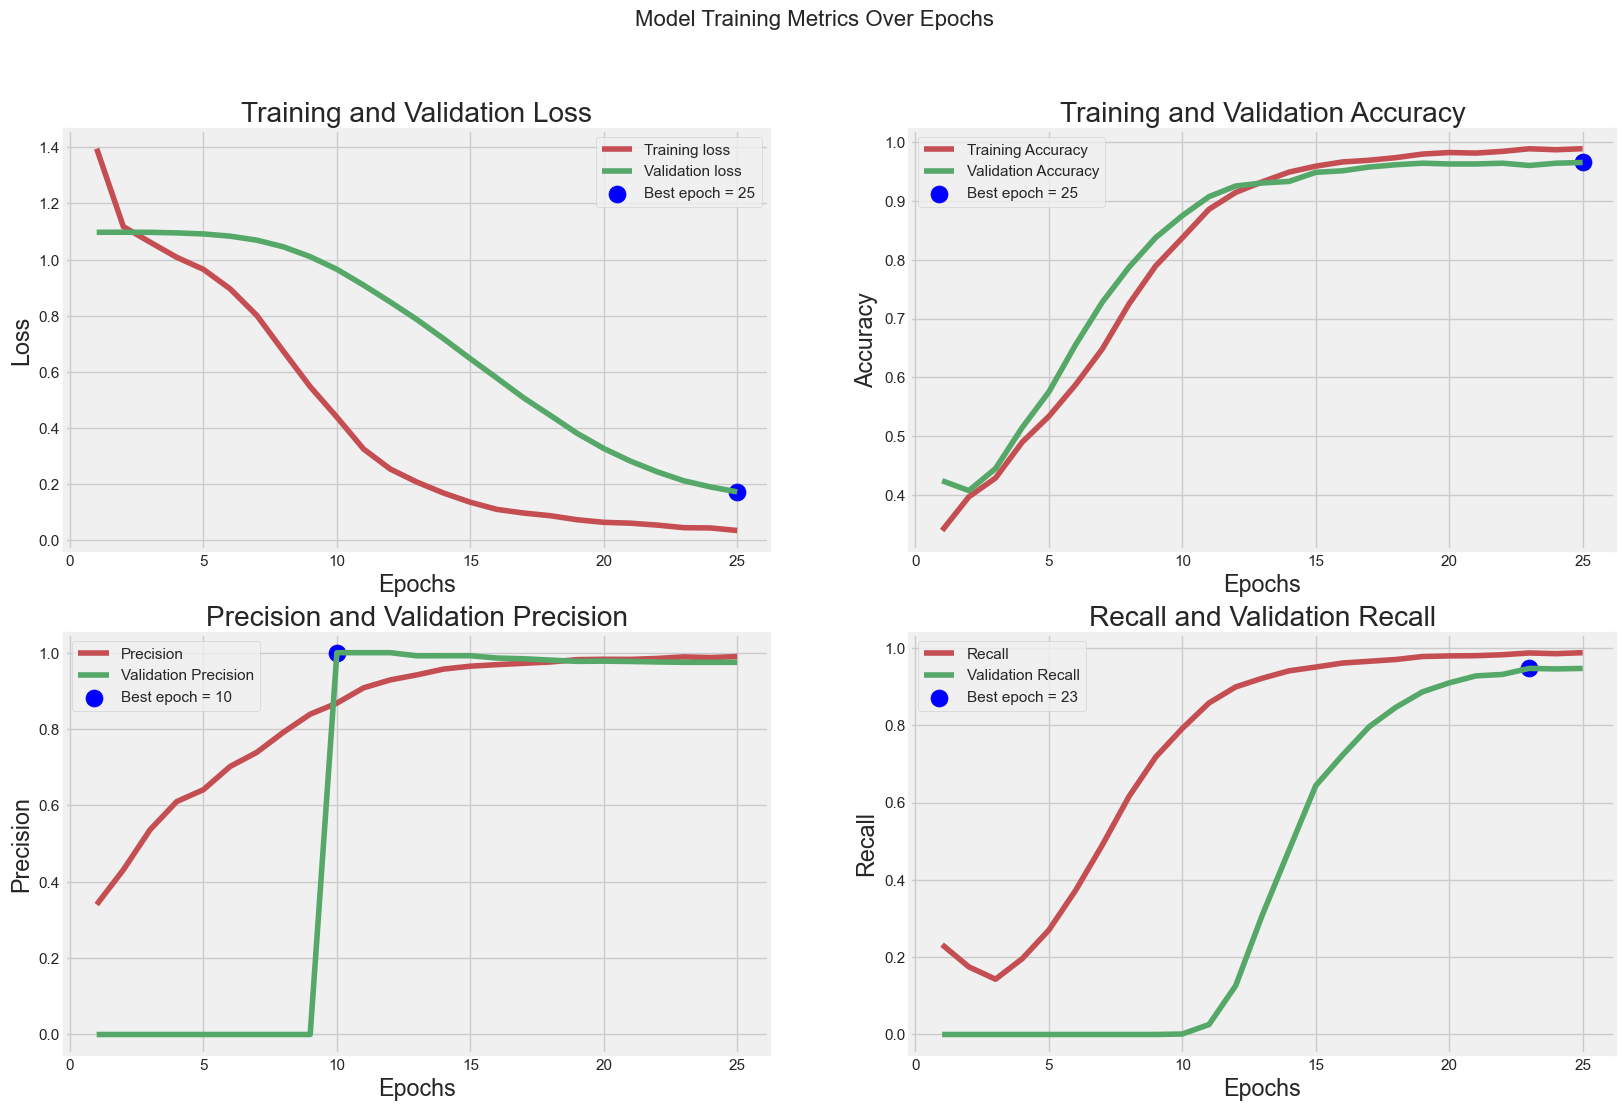

In [33]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision']
tr_recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision']
val_recall = history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


# plt.figure(figsize=(20, 12))
# plt.style.use('fivethirtyeight')


# plt.subplot(2, 2, 1)
# plt.plot(Epochs, tr_loss, 'r', label='Training loss')
# plt.plot(Epochs, val_loss, 'g', label='Validation loss')
# plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 2, 2)
# plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
# plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
# plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 2, 3)
# plt.plot(Epochs, tr_per, 'r', label='Precision')
# plt.plot(Epochs, val_per, 'g', label='Validation Precision')
# plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
# plt.title('Precision and Validation Precision')
# plt.xlabel('Epochs')
# plt.ylabel('Precision')
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 2, 4)
# plt.plot(Epochs, tr_recall, 'r', label='Recall')
# plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
# plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
# plt.title('Recall and Validation Recall')
# plt.xlabel('Epochs')
# plt.ylabel('Recall')
# plt.legend()
# plt.grid(True)

# plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
# plt.show()

Kwang Zhe: We can see from the graphs that Loss, Accuracy and Recall all hit their lowest loss amount and higher accuracy and recall percentages at Epoch 25. <br>
However, Precision hit its maximum at Epoch 10, and slowly started de-proving in subsequenct Epochs.

Kwang Zhe: In the case of predicting emotion from sentence inputs, both False Positives and Negatives are nearly equally important.
<br> However, since Precision at Epoch 25 did not decrease significantly from its highest percentage, the model's overall accuracy is still acceptable.

Kwang Zhe: To prove this, F1 Score is calculated. We will use the Validation scores for the computation.

In [34]:
# Index 24 is extracted to obtain the 25th Epoch in the Arrays.
f1_score = 2 * ((val_per[24] * val_recall[24]) / (val_per[24] + val_recall[24]))
# print(f1_score)

0.9607329936942898


In [35]:
y_true=[]
for i in range(len(ts_y)):
    
    x = np.argmax(ts_y[i]) 
    y_true.append(x)

In [36]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
# y_pred

25/25 [==============================] - 5s 3ms/step


array([2, 1, 0, 2, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 1, 1, 0, 0, 1, 1, 0, 1,
       2, 2, 2, 1, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2,
       0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0,
       2, 1, 2, 2, 1, 0, 1, 0, 2, 0, 2, 2, 0, 1, 2, 1, 2, 1, 2, 1, 0, 2,
       1, 0, 2, 2, 0, 2, 0, 0, 1, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 1, 2, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 0, 2, 1, 0, 2, 2, 0, 1, 1,
       1, 2, 2, 1, 0, 1, 1, 1, 2, 2, 1, 0, 1, 1, 0, 0, 2, 1, 1, 2, 1, 1,
       1, 0, 2, 0, 1, 0, 2, 1, 1, 2, 2, 0, 0, 2, 1, 0, 0, 0, 1, 1, 2, 0,
       1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 1, 2, 1, 2, 0, 2, 2, 0, 2, 2, 2, 0,
       0, 0, 2, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 2, 1, 2, 0, 2, 0, 2, 2, 2,
       2, 0, 2, 0, 1, 2, 2, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1, 0, 1,
       1, 0, 0, 0, 2, 1, 1, 2, 2, 2, 0, 0, 0, 1, 0, 1, 2, 2, 2, 2, 2, 2,
       2, 1, 0, 1, 0, 1, 0, 0, 1, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 2, 2, 0,
       0, 1, 1, 2, 2, 2, 2, 1, 0, 1, 2, 0, 2, 1, 2,

<Axes: >

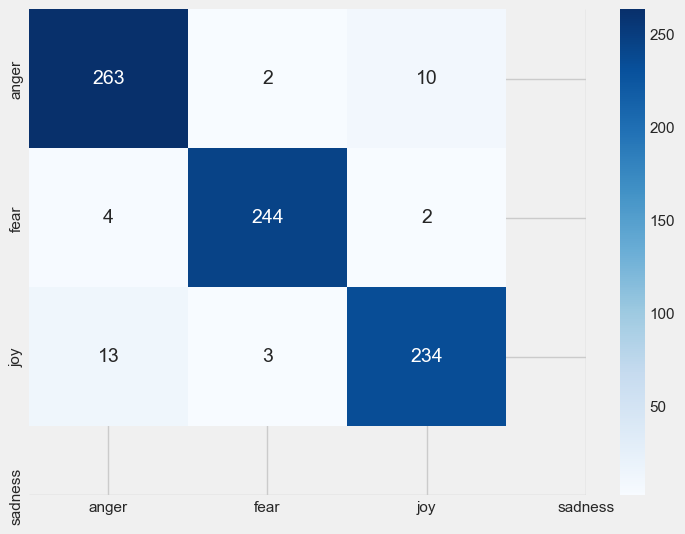

In [37]:
plt.figure(figsize=(8,6))
emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'sadness'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

In [38]:
clr = classification_report(y_true, y_pred)
# print(clr)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       275
           1       0.98      0.98      0.98       250
           2       0.95      0.94      0.94       250

    accuracy                           0.96       775
   macro avg       0.96      0.96      0.96       775
weighted avg       0.96      0.96      0.96       775



# 5. Save model

In [39]:
import pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('nlp.h5')

c:\Users\yukwa\is217anaconda3\anaconda3\envs\is217_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 6. Prediction function

Kwang Zhe: Here, 'fear' is also taken out to compensate for the adjustments earlier.

In [49]:
def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import matplotlib.pyplot as plt
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model(model_path)
    
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=50)
    predictions = model.predict([x_new, x_new])
    
    emotions = {0: 'anger', 1: 'joy', 2:'sadness'} # Removed 'fear' from the dictionary.
    
    label = list(emotions.values())
    probs = list(predictions[0])
    labels = label
    # plt.subplot(1, 1, 1)
    # bars = plt.barh(labels, probs)
    # plt.xlabel('Probability', fontsize=15)
    # ax = plt.gca()
    # ax.bar_label(bars, fmt = '%.2f')
    # plt.show()
    
    return probs # Added in this return value to obtain the probability distrbution from each sentiment analysis.

1/1 [==============================] - 0s 142ms/step


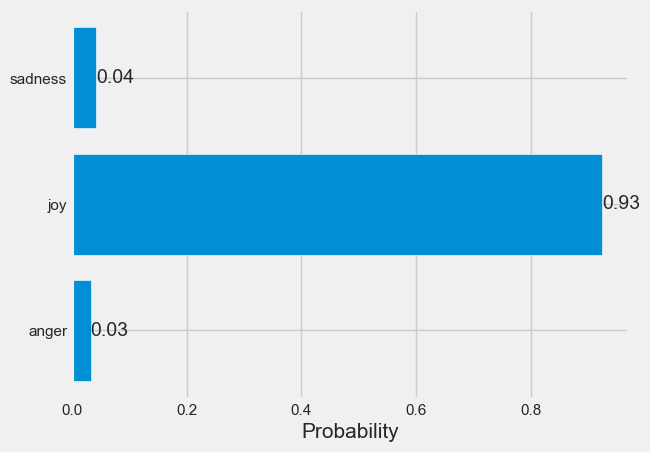

[0.0323943, 0.9252858, 0.04231987]

In [50]:
# txt = 'I am very happy to finish this project'
# predict(txt, 'nlp.h5', 'tokenizer.pkl')

1/1 [==============================] - 0s 157ms/step


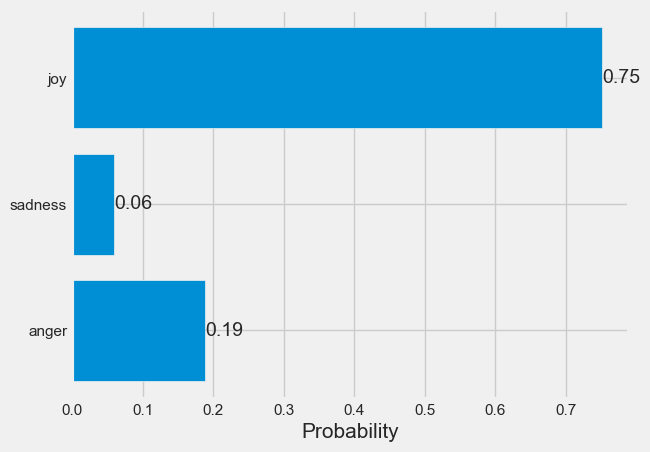

[0.18851283, 0.059930112, 0.75155705]

In [42]:
# txt = 'I am very sad'
# predict(txt, 'nlp.h5', 'tokenizer.pkl')

1/1 [==============================] - 0s 334ms/step


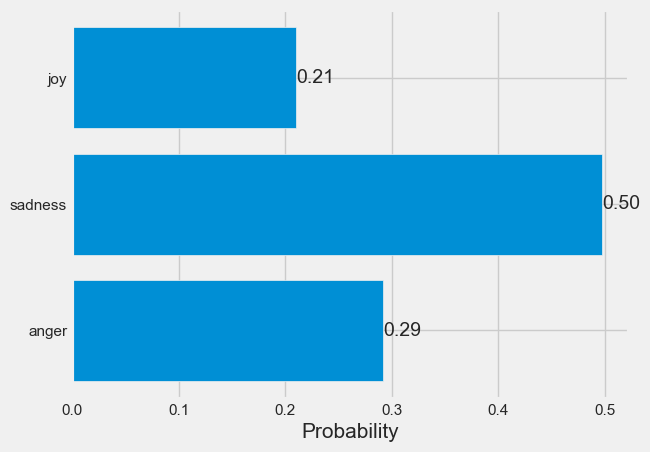

[0.2918444, 0.4977459, 0.21040973]

In [43]:
# txt = 'Ahhhhhhhhhhhh, I wanna kill myself.'
# predict(txt, 'nlp.h5', 'tokenizer.pkl')

1/1 [==============================] - 0s 142ms/step


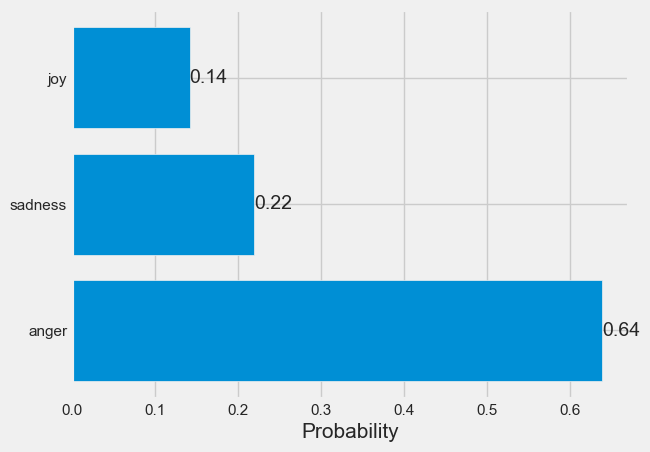

[0.6392482, 0.2190282, 0.14172356]


In [44]:
# txt = "I'm going to murder someone."
# prediction = predict(txt, 'nlp.h5', 'tokenizer.pkl')
# print(prediction)

Kwang Zhe: From some trial and error, the inputs have the be very emotive and expressive to obtain the inutionally correct result. <br>
Short sentences work more times than not, but longer sentences returns more accurate results. <br>
May be due to the pre-defined and somewhat limited dataset. Could take from more sources for training.

# Output

1/1 [==============================] - 0s 124ms/step


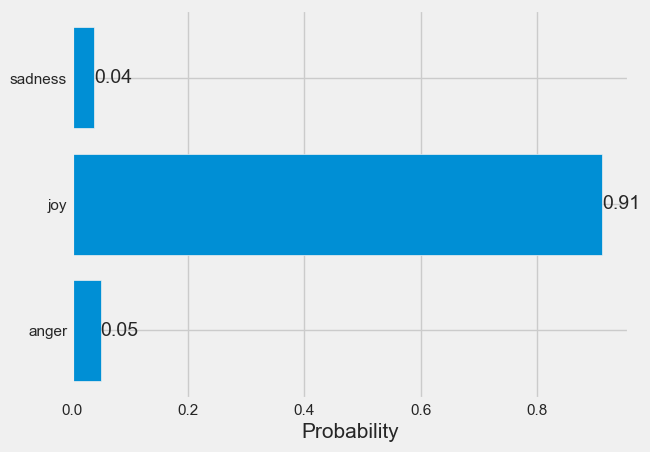

In [51]:
output_value = predict(input_sentence, 'nlp.h5', 'tokenizer.pkl')

In [52]:
np.savetxt('data\emotions_prob.txt', [output_value[1], output_value[2], output_value[0]])